In [330]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy import units as u
import astropy.cosmology.units as cu
from astropy.cosmology import FlatLambdaCDM
from matplotlib import colors
import matplotlib as mpl
import pyCloudy as pc

In [331]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update(
    {
        "text.usetex": True,
        # "font.family": "Helvetica",
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "font.size": 8,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "ytick.right": True,
        "xtick.top": True,
        # "axes.linewidth": ,
    }
)

Here we'll look at two distinct IMFs



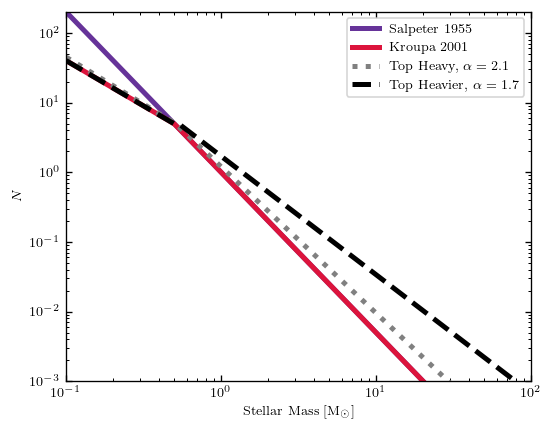

In [332]:
masses = np.geomspace(0.1, 100, 100)


def salp(m, gamma=2.3):
    return m**-gamma


def kroupa(m):
    output = np.zeros_like(m)
    mask1 = (m >= 0.1) & (m < 0.5)
    mask2 = m >= 0.5
    output[mask1] = 2 * m[mask1] ** -1.3
    output[mask2] = m[mask2] ** -2.3
    return output


def top_heavy1(m, alpha=1.7):
    output = np.zeros_like(m)
    mask1 = (m >= 0.1) & (m < 0.5)
    mask2 = m >= 0.5
    output[mask1] = 2 * m[mask1] ** -1.3
    output[mask2] = alpha * m[mask2] ** -alpha
    return output


def top_heavy2(m, alpha):
    output = np.zeros_like(m)
    mask1 = (m >= 0.1) & (m < 0.5)
    mask2 = m >= 0.5
    output[mask1] = 2 * m[mask1] ** -1.35
    output[mask2] = 1.2 * m[mask2] ** -alpha
    return output


fig, ax = plt.subplots(1, 1, dpi=120, figsize=(5, 4))
ax.plot(masses, salp(masses), lw=3, color="rebeccapurple", label="Salpeter 1955")
ax.plot(masses, kroupa(masses), lw=3, color="crimson", label="Kroupa 2001")
ax.plot(
    masses,
    top_heavy2(masses, alpha=2.1),
    lw=3,
    color="grey",
    ls=":",
    label=r"Top Heavy, $\alpha = 2.1$",
)
ax.plot(
    masses,
    top_heavy1(masses, alpha=1.7),
    lw=3,
    color="black",
    ls="--",
    label=r"Top Heavier, $\alpha = 1.7$",
)
ax.set(
    xscale="log",
    yscale="log",
    xlim=(0.1, 100),
    ylim=(1e-3, 200),
    xlabel=r"Stellar Mass [M$_\odot$]",
    ylabel=r"$N$",
)
ax.legend()
plt.show()
plt.savefig("imf.png")

Here we load the synthetic spectrum, which is tabulated
```
TIME [YR] WAVELENGTH[A]  LOG TOTAL  LOG STELLAR  LOG NEBULAR[ERG/SEC/A]
```
note, for a given time in the `TIME [YR]`, there is an associated wavelength value for each other columns.

So, there are repeating `TIME [YR]` values set for a given age of (e.g.) of which has varying LOG TOTAL LUMINOSITY, etc.

In [333]:
time, wvlngth, log_total_lum = np.loadtxt(
    "kroupa_output/kroupatest.spectrum1", unpack=True, usecols=(0, 1, 2), skiprows=6
)

# convert time
tmyr = time / 1e6
wav_ang = wvlngth

Here are the actual unique times in Myr, note it is accurate up to around 100 Myr

In [334]:
np.unique(tmyr)

array([1.000e-02, 2.010e+00, 4.010e+00, 6.010e+00, 8.010e+00, 1.001e+01,
       1.201e+01, 1.401e+01, 1.601e+01, 1.801e+01, 2.001e+01, 2.201e+01,
       2.401e+01, 2.601e+01, 2.801e+01, 3.001e+01, 3.201e+01, 3.401e+01,
       3.601e+01, 3.801e+01, 4.001e+01, 4.201e+01, 4.401e+01, 4.601e+01,
       4.801e+01, 5.001e+01, 5.201e+01, 5.401e+01, 5.601e+01, 5.801e+01,
       6.001e+01, 6.201e+01, 6.401e+01, 6.601e+01, 6.801e+01, 7.001e+01,
       7.201e+01, 7.401e+01, 7.601e+01, 7.801e+01, 8.001e+01, 8.201e+01,
       8.401e+01, 8.601e+01, 8.801e+01, 9.001e+01, 9.201e+01, 9.401e+01,
       9.601e+01, 9.801e+01])

we can wrap this in a function so that we only return the specturm at approximately wanted_time

while we're at it we can also calculate being able to see how it changes if we place it to a given redshift (z) for a given observed Flux $F_{\rm obs}$ and wavelength $\lambda$

$$
\lambda_{\rm obs} = \lambda(1+z) 
$$

$$
F_{\rm obs} = \dfrac{L}{ 4 \pi d_L^2}
$$

for a given restframe luminosity (which we have from starburst99), luminosity distance, which depends on redshift.

In [335]:
def get_spectrum(file, wanted_tmyr, type="total"):
    if type == "total":
        time, wvlngth, lum = np.loadtxt(
            file, unpack=True, usecols=(0, 1, 2), skiprows=6
        )
    elif type == "stellar":
        time, wvlngth, lum = np.loadtxt(
            file, unpack=True, usecols=(0, 1, 3), skiprows=6
        )
    elif type == "nebular":
        time, wvlngth, lum = np.loadtxt(
            file, unpack=True, usecols=(0, 1, 4), skiprows=6
        )
    else:
        print("type on valid")
        exit()

    # convert time
    tmyr = time / 1e6
    wav_ang = wvlngth * u.Angstrom

    # since it is a table, get the closest Myr to it
    wanted_idx = np.argmin(np.abs(np.unique(tmyr) - wanted_tmyr))
    closest_time = np.unique(tmyr)[wanted_idx]
    # print("Closest time to wanted time: {} Myr".format(closest_time))
    valid_time_mask = tmyr == closest_time

    wav = wav_ang[valid_time_mask]
    log_total_luminosity = lum[valid_time_mask]
    luminosity = 10**log_total_luminosity * (u.erg / u.s / u.Angstrom)

    return wav.to("micron").value, luminosity.value

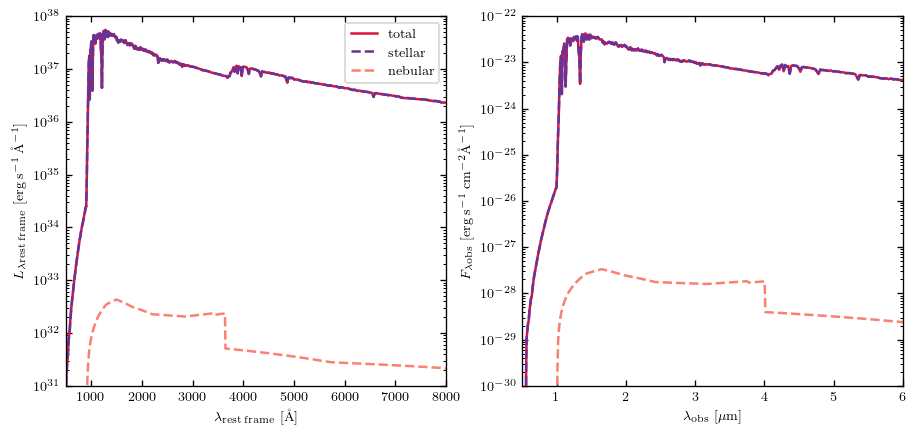

In [393]:
tmyr = 50

def observed_flux_calc(wav, lum, redshift):
    cosmology = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
    lum_distance = cosmology.luminosity_distance(redshift).to("cm")
    observed_flux = lum / (4 * np.pi * lum_distance**2)
    observed_wavlength = wav * (1 + redshift)
    return observed_wavlength, observed_flux


wav, lum_total = get_spectrum(
    "kroupa_output/kroupatest.spectrum1", wanted_tmyr=tmyr, type="total"
)
observed_wavlength, observed_flux = observed_flux_calc(wav, lum_total, redshift=10)

_, lum_stellar = get_spectrum(
    "kroupa_output/kroupatest.spectrum1", wanted_tmyr=tmyr, type="stellar"
)
_, observed_flux_stellar = observed_flux_calc(wav, lum_stellar, redshift=10)

_, lum_nebular = get_spectrum(
    "kroupa_output/kroupatest.spectrum1", wanted_tmyr=tmyr, type="nebular"
)
_, observed_flux_nebular= observed_flux_calc(wav, lum_nebular, redshift=10)

fig, ax = plt.subplots(
    1,
    2,
    dpi=120,
    figsize=(9, 4),
)
# plot from micron to Angstrom
ax[0]. plot(wav * 1e4, lum_total, color="crimson",
    label="total")
ax[0].plot(
    wav * 1e4,
    lum_stellar,
    color="rebeccapurple",
    label="stellar",
    ls="--"
)
ax[0].plot(
    wav * 1e4,
    lum_nebular,
      color="salmon",
    label="nebular",
    ls="--"
)
ax[0].set(
    yscale="log",
    ylim=(1e31,1e38),
    xlim=(500,8e3),
    xlabel=r"$\lambda_{\rm rest \, frame}$ [$\mathrm{\AA}$]",
    ylabel=r"$L_{\lambda {\rm rest \, frame}}$ [${\rm erg \: s^{-1} \: \AA^{-1}}$]",
)


ax[1].plot(
    observed_wavlength,
    observed_flux,
    color="crimson",
    label="total"
)
ax[1].plot(
    observed_wavlength,
    observed_flux_stellar,
    color="rebeccapurple",
    label="stellar",
    ls="--"
)
ax[1].plot(
    observed_wavlength,
    observed_flux_nebular,
    color="salmon",
    label="nebular",
    ls="--"
    
)
ax[1].set(
    xlim=(0.5, 6),
    yscale="log",
    ylim=(1e-30, 1e-22),
    xlabel=r"$\lambda_{\rm obs}$ [$\mu$m]",
    ylabel=r"$F_{\lambda {\rm obs}}$ [${\rm erg \: s^{-1} \: cm^{-2} \AA^{-1}}$]",
)

ax[0].legend()
plt.show()

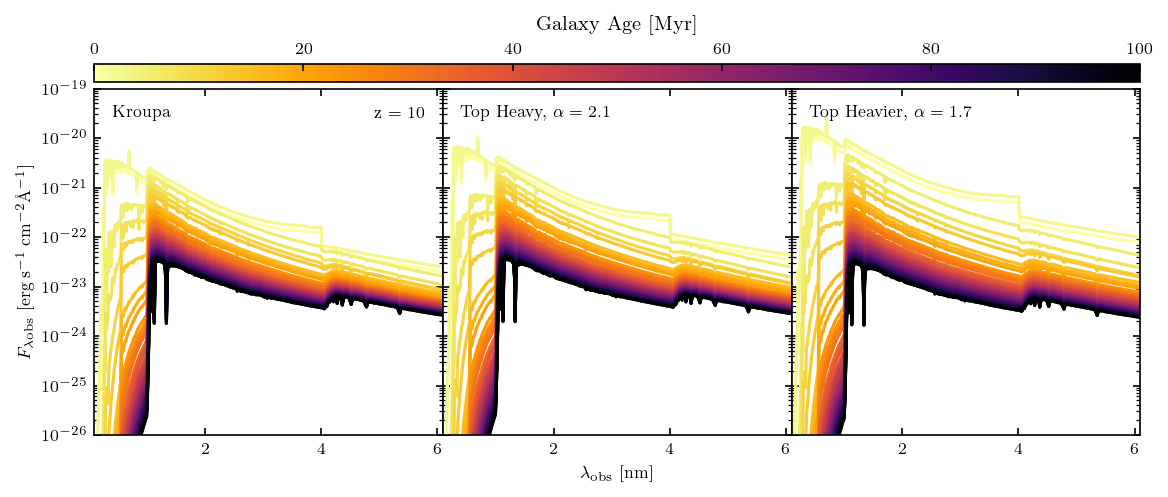

In [397]:
# let's loop through all the lines

redshift = 8
tmyrs = np.linspace(0.0, 100, 40)

fig, ax = plt.subplots(1, 3, dpi=150, figsize=(9, 3), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)
cbar_ax = ax[0].inset_axes([0, 1.02, 3, 0.05])

cmap = plt.cm.inferno_r
norm = colors.Normalize(vmin=np.min(tmyrs), vmax=np.max(tmyrs))
cb = mpl.colorbar.ColorbarBase(
    cbar_ax,
    cmap=cmap,
    norm=norm,
    orientation="horizontal",
)

for t in tmyrs:
    wav, lum = get_spectrum("kroupa_metal1e-4/kroupa_metal1e-4.spectrum1", wanted_tmyr=t)
    observed_wavlength, observed_flux = observed_flux_calc(wav, lum, redshift=10)
    ax[0].plot(observed_wavlength, observed_flux, color=cmap(norm(t)))

for t in tmyrs:
    wav, lum = get_spectrum("topheavy_metal1e-4/topheavy_metal1e-4.spectrum1", wanted_tmyr=t)
    observed_wavlength, observed_flux = observed_flux_calc(wav, lum, redshift=10)
    ax[1].plot(observed_wavlength, observed_flux, color=cmap(norm(t)))
    
for t in tmyrs:
    wav, lum = get_spectrum("topheavier_metal1e-4/topheavier_metal1e-4.spectrum1", wanted_tmyr=t)
    observed_wavlength, observed_flux = observed_flux_calc(wav, lum, redshift=10)
    ax[2].plot(observed_wavlength, observed_flux, color=cmap(norm(t)))

ax[0].set(
    xlim=(0.09, 6.1),
    yscale="log",
    ylim=(1e-26, 1e-19),
    ylabel=r"$F_{\lambda {\rm obs}}$ [${\rm erg \: s^{-1} \: cm^{-2} \AA^{-1}}$]",
)

ax[1].set(xlabel=r"$\lambda_{\rm obs}$ [nm]")
cbar_ax.set(title=r"Galaxy Age [Myr]")
cbar_ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax[0].text(0.95, 0.95, "z = 10", va="top", ha="right", transform=ax[0].transAxes)
ax[0].text(0.05, 0.95, "Kroupa", va="top", ha="left", transform=ax[0].transAxes)
ax[1].text(
    0.05,
    0.95,
    r"Top Heavy, $\alpha  =2.1$",
    va="top",
    ha="left",
    transform=ax[1].transAxes,
)
ax[2].text(
    0.05,
    0.95,
    r"Top Heavier, $\alpha  =1.7$",
    va="top",
    ha="left",
    transform=ax[2].transAxes,
)

# ax.legend(title="Kroupa, z = 10")
plt.savefig("kroupa_spectrum.png")
plt.show()

Here we show the observed total continuum spectra (stellar + nebular) for a galaxy of mass $10^6~ M_\odot$ at z = 10, colored by the age of the galaxy. The stars have a metallicity of 0.020 and served as a test run of Starburst99. Note that below we actually show what spectra we will feed into Cloudy, which has lower metallicity.